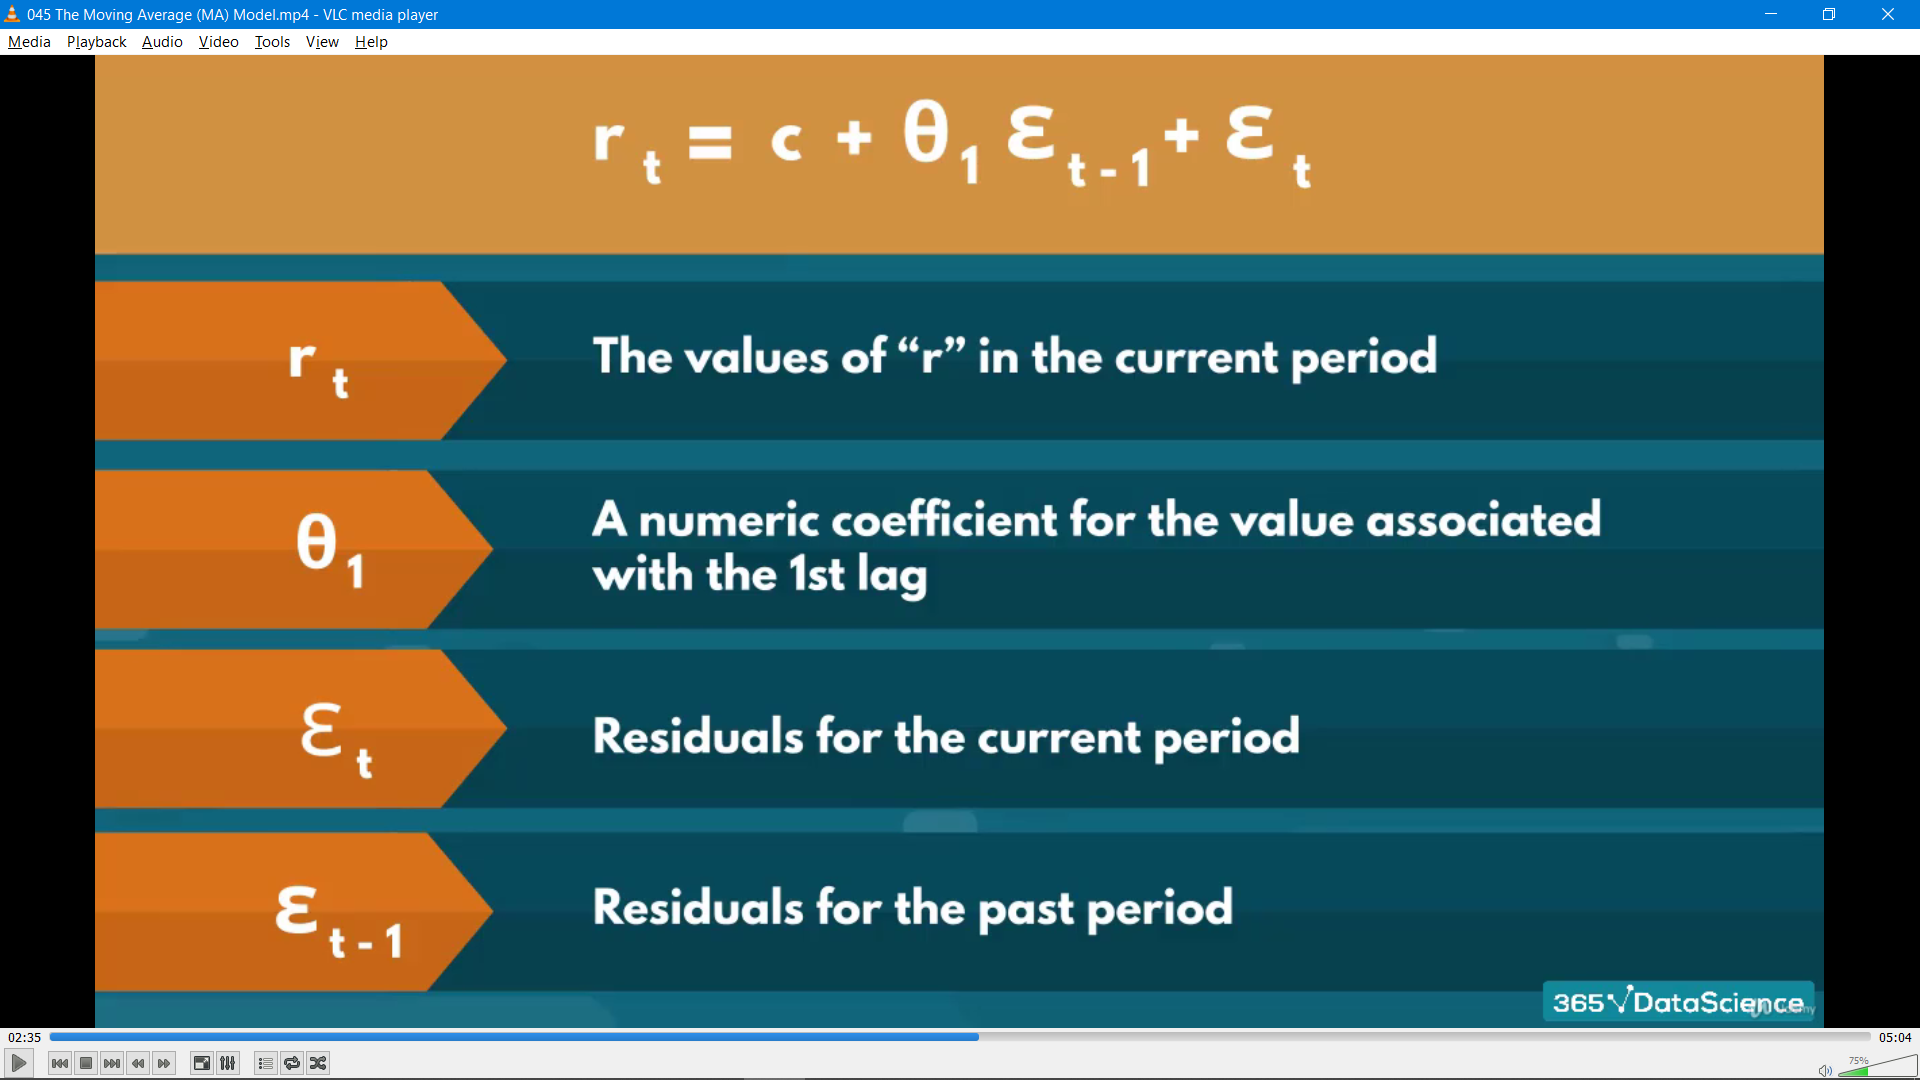

The AR Model relies on the value of the variable, while the MA model relies on the residual.   (However both has to be lower than 1, to prevent value exponetiation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

In [15]:
raw_csv_data = pd.read_csv("013 IndexE8.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date,dayfirst=True)
df_comp.set_index("date",inplace=True)
df_comp = df_comp.asfreq("b")
df_comp = df_comp.fillna(method="ffill")

In [16]:
df_comp['market_value'] = df_comp.ftse

In [17]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [18]:
df["returns"] = df.market_value.pct_change(1).mul(100)
df.head()

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


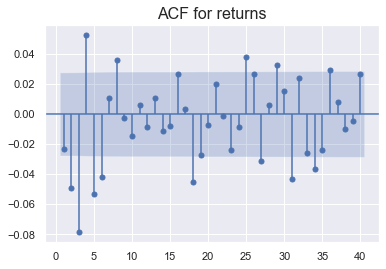

In [20]:
sgt.plot_acf(df.returns[1:],zero=False,lags=40)
plt.title("ACF for returns",size=16)
plt.show()

In [26]:
# Judging by the above graph, a good model will show higher p-value for the first lag, as it is less correlated

In [28]:
# MA(1) for returns

model_ret_ma_1 = ARMA(df.returns[1:],order=(0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Sat, 03 Apr 2021   AIC                          15865.190
Time:                        00:13:16   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8547           +0.0000j           38.8547            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
def LLR_test(mod_1,mod_2, df=1):
    l1 = mod_1.fit().llf
    l2 = mod_2.fit().llf
    LR = (2*(l2-l1))
    p = chi2.sf(LR,df).round(3)
    return p

In [34]:
for i in range(1,11):
    model_i = ARMA(df.returns[1:],order=(0,i))
    model_i_plus_1 = ARMA(df.returns[1:],order=(0,i+1))
    
    test_result = LLR_test(model_i,model_i_plus_1)
    
    if test_result <= 0.05:
        print("Lag(s)",i+1,test_result,"[SIGNIFICANT]")
    else:
        print("Lag(s)",i+1,test_result,"[NOT SIGNIFICANT]")

Lag(s) 2 0.0 [SIGNIFICANT]
Lag(s) 3 0.0 [SIGNIFICANT]
Lag(s) 4 0.001 [SIGNIFICANT]
Lag(s) 5 0.001 [SIGNIFICANT]
Lag(s) 6 0.007 [SIGNIFICANT]
Lag(s) 7 0.554 [NOT SIGNIFICANT]
Lag(s) 8 0.009 [SIGNIFICANT]
Lag(s) 9 0.59 [NOT SIGNIFICANT]
Lag(s) 10 0.483 [NOT SIGNIFICANT]
Lag(s) 11 0.444 [NOT SIGNIFICANT]


In [ ]:
# Above the 7th model is not significant, but 8th is , so we have to run LLR test b/w 6th and 8th lagged model
# with degrees of freedom = 2, instead of 1
# and that will give the result 0.027, which is lesser than 0.05 significance level.
# so 8th performed well

In [35]:
# Residuals for returns

model_ret_ma_8 = ARMA(df.returns[1:],order=(0,8))
results_ret_ma_8 = model_ret_ma_8.fit()

df['res_ret_ma_8'] = results_ret_ma_8.resid

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on 

In [39]:
df.res_ret_ma_8.mean().round(3),df.res_ret_ma_8.std().round(3)

(-0.0, 1.164)

In [42]:
# Above residuals are similar to gaussian white noise, so in 3stds, meaning (3*1.164) = 3.479 in both directions

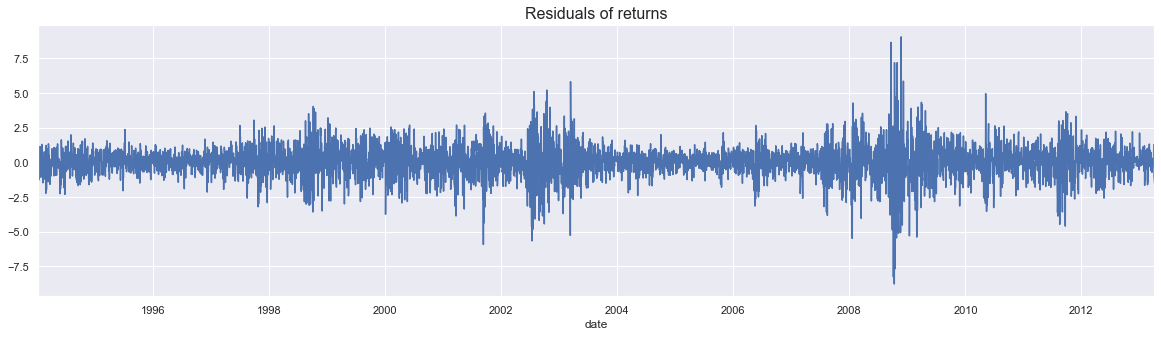

In [52]:
df.res_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of returns",size=16)
plt.show()

In [53]:
# Let's check for stationary, if it is non stationary it can't be white noise

In [59]:
import statsmodels.tsa.stattools as sts
sts.adfuller(df.res_ret_ma_8[2:])

# Yes it is stationary but not so fast , we should also examine the ACF

# A white noise is random data so most acf cofficient must be near zero

(-70.8358159984477,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.05218476884)

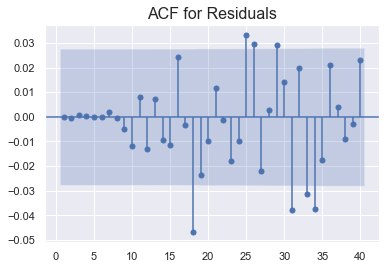

In [62]:
sgt.plot_acf(df.res_ret_ma_8[2:],zero=False,lags=40)
plt.title("ACF for Residuals",size=16)
plt.show()

In [ ]:
# Yes mostly coeffs are insignificant, or in blue region, the first 8 are obviosuly insignificant cuz they are incorporated into the model

In [64]:
# Now see how MA models will perform for Normalized data

In [65]:
# Normalization
benchmark = df.returns[1]
df["norm_ret"] = df.returns.div(benchmark).mul(100)
df.head(3)

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,market_value,returns,res_ret_ma_8,norm_ret
date,,,,
1994-01-07,3445.98,NaN,NaN,NaN
1994-01-10,3440.58,-0.156704,-0.175611,100.000000
1994-01-11,3413.77,-0.779229,-0.802111,497.260711


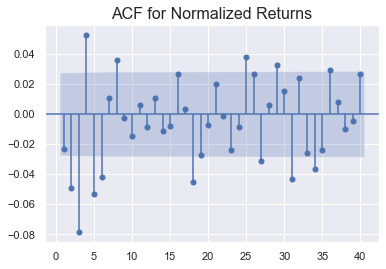

In [67]:
sgt.plot_acf(df.norm_ret[1:],zero=False,lags=40)
plt.title("ACF for Normalized Returns",size=16)
plt.show()

In [70]:
model_norm_ret_ma_8 = ARMA(df.norm_ret[1:],order=(0,8))
results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
print(results_norm_ret_ma_8.summary())

                              ARMA Model Results                              
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood              -40307.597
Method:                       css-mle   S.D. of innovations            742.822
Date:                Sat, 03 Apr 2021   AIC                          80635.194
Time:                        02:11:39   BIC                          80700.406
Sample:                    01-10-1994   HQIC                         80658.045
                         - 04-05-2013                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.846     -1.354      0.176     -29.310       5.364
ma.L1.norm_ret    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0495      0.014

In [ ]:
# Once again we see normalizing the data doesn't affect model selection

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


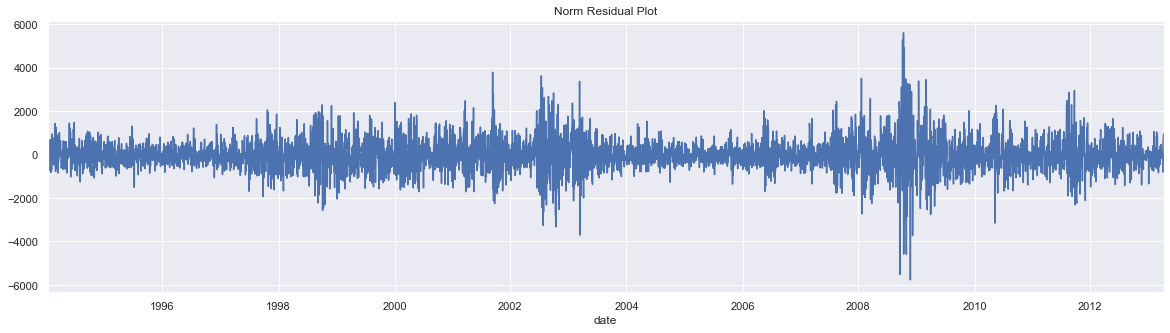

In [71]:
df['res_norm_ret_ma_8'] = results_norm_ret_ma_8.resid[1:]
df.res_norm_ret_ma_8.plot(figsize=(20,5))
plt.title("Norm Residual Plot")
plt.show()

In [74]:
sts.adfuller(df.res_norm_ret_ma_8[2:]) # Yes it suggest stationary series, it's a white noise also seen by ACF below

(-70.8358060459262,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 80088.85897083505)

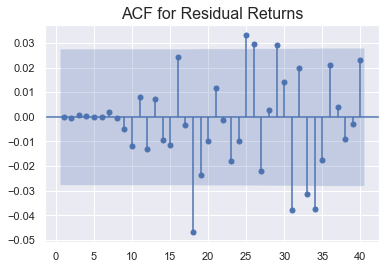

In [76]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:],zero=False,lags=40)
plt.title("ACF for Residual Returns",size=16)
plt.show()

In [77]:
### Fitting MA model for prices

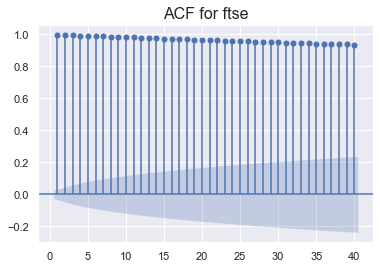

In [81]:
sgt.plot_acf(df.market_value,zero=False,lags=40)
plt.title("ACF for ftse",size=16)
plt.show()

In [ ]:
# here no Moving Average Model will be good estimator of the prices, as all the lags are significant, and it requires
# infinite lags ma model, and every higher lag model will be better than the lower one. Hence MA no good for prices.

In [82]:
model_ma_1 = ARMA(df.market_value,order=(0,1))
results_ma_1 = model_ma_1.fit()
print(results_ma_1.summary())

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(0, 1)   Log Likelihood              -38629.000
Method:                       css-mle   S.D. of innovations            530.756
Date:                Sat, 03 Apr 2021   AIC                          77264.000
Time:                        02:52:18   BIC                          77283.564
Sample:                    01-07-1994   HQIC                         77270.856
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6144     14.660    347.188      0.000    5060.882    5118.347
ma.L1.market_value     0.9573      0.003    335.559      0.000       0.952       0.963
                    

In [83]:
for i in range(1,21):
    model_i = ARMA(df.market_value,order=(0,i))
    model_i_plus_1 = ARMA(df.market_value,order=(0,i+1))
    
    test_result = LLR_test(model_i,model_i_plus_1)
    
    if test_result <= 0.05:
        print("Lag(s)",i+1,test_result,"[SIGNIFICANT]")
    else:
        print("Lag(s)",i+1,test_result,"[NOT SIGNIFICANT]")

C:\Users\Pankaj Choudhary\Anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Lag(s) 2 0.0 [SIGNIFICANT]
Lag(s) 3 0.0 [SIGNIFICANT]
Lag(s) 4 0.0 [SIGNIFICANT]
Lag(s) 5 0.0 [SIGNIFICANT]
Lag(s) 6 0.0 [SIGNIFICANT]
Lag(s) 7 0.0 [SIGNIFICANT]
Lag(s) 8 0.0 [SIGNIFICANT]
Lag(s) 9 0.0 [SIGNIFICANT]
Lag(s) 10 0.0 [SIGNIFICANT]
Lag(s) 11 0.0 [SIGNIFICANT]
Lag(s) 12 0.0 [SIGNIFICANT]
Lag(s) 13 0.0 [SIGNIFICANT]
Lag(s) 14 0.0 [SIGNIFICANT]
Lag(s) 15 0.0 [SIGNIFICANT]


KeyboardInterrupt: 

In [ ]:
# MA model do not perform well for non stationary data